## STMO Project

In [49]:
import osmnx as ox
import networkx as nx
import numpy as np
import random
import matplotlib.pyplot as plt
from geopy.geocoders import Nominatim
from ipywidgets import interact, IntSlider

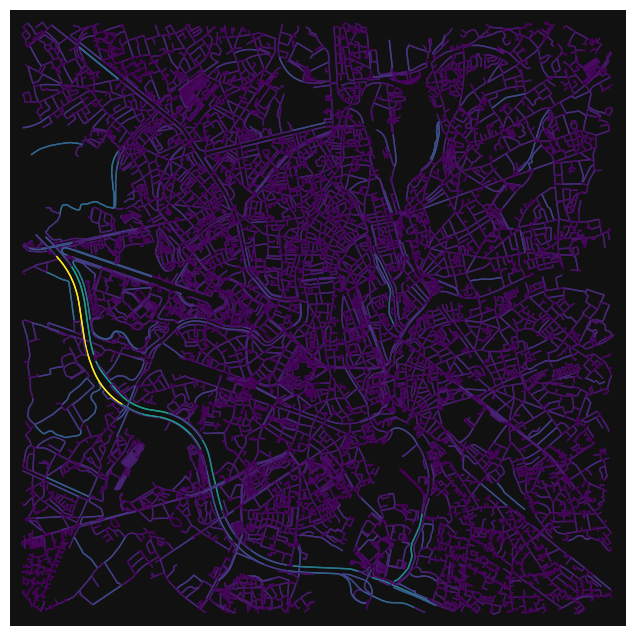

(<Figure size 800x800 with 1 Axes>, <Axes: >)

In [95]:
# Define the address as a starting point
center = "Sint-kwintensberg 74, Ghent, Belgium"
geolocator = Nominatim(user_agent="STMO_project")

# Geocode the address to get its latitude and longitude
center_point = ox.geocode(center)

# Define the buffer distance (in meters) for the map area
buffer_distance = 4000  # 6 km radius

# Download the street network data within the buffer distance around the center point
graph = ox.graph_from_point(center_point, dist=buffer_distance, network_type='walk')
graph = ox.distance.add_edge_lengths(graph)

# Plot the graph to verify
ec = ox.plot.get_edge_colors_by_attr(graph, attr='length')
ox.plot_graph(graph, edge_color=ec, node_alpha=0)

In [16]:
city_nodes, city_edges = ox.graph_to_gdfs(graph)
city_nodes

,y,x,street_count,highway,railway,ref,geometry
osmid,,,,,,,
145679,51.003726,3.769753,1,NaN,NaN,NaN,POINT (3.76975 51.00373)
145715,51.012885,3.734588,3,NaN,NaN,NaN,POINT (3.73459 51.01288)
145763,51.031829,3.732254,3,NaN,NaN,NaN,POINT (3.73225 51.03183)
145785,51.038644,3.725182,3,NaN,NaN,NaN,POINT (3.72518 51.03864)
145786,51.039828,3.723309,4,NaN,NaN,NaN,POINT (3.72331 51.03983)
...,...,...,...,...,...,...,...
12431244681,51.095528,3.795176,3,NaN,NaN,NaN,POINT (3.79518 51.09553)
12431669915,51.069330,3.782478,3,NaN,NaN,NaN,POINT (3.78248 51.06933)
12431669917,51.069350,3.782983,3,NaN,NaN,NaN,POINT (3.78298 51.06935)


In [17]:
city_edges.name

u            v            key
145679       96158030     0                               Buitenring Merelbeke
145715       56537191     0                              Binnenring-Zwijnaarde
             205294656    0      [Binnenring Merelbeke, Binnenring-Zwijnaarde]
             2040932329   0                                                NaN
145763       10608884795  0          [Achilles Heyndrickxlaan, Burggravenlaan]
                                                     ...                      
12431669918  7938348732   0                                 Achtenkouterstraat
             12431669926  0                                                NaN
12431669926  12431669918  0                                                NaN
             1453819527   0                                                NaN
             12312641478  0                                                NaN
Name: name, Length: 76582, dtype: object

In [33]:
def translate_address(graph, geolocator, address: str, return_coords=False):
    """
    Translate an address to a corresponding node in the specified graph.

    Parameters:
    ----------
    graph : networkx.MultiDiGraph
        The graph network to search, typically an OSMnx graph.
    geolocator : geopy.geocoders
        The geolocator instance used to geocode the address.
    address : str
        A valid address that is expected to correspond to a location within the graph.
    return_coords : bool, optional
        If True, returns the coordinates of the node along with the node object. Default is False.

    Returns:
    -------
    node : int
        The nearest node's osmid in the graph.
    start_lon : float
        Longitude of the nearest node (only if return_coords=True).
    start_lat : float
        Latitude of the nearest node (only if return_coords=True).

    Raises:
    ------
    AssertionError
        If the address cannot be located or mapped to a node in the graph.
    """

    # Geocode the address to get latitude and longitude
    location = geolocator.geocode(address)
    if location is None:
        raise ValueError(f"Address '{address}' could not be geocoded.")

    start_lat, start_lon = location.latitude, location.longitude

    # Find the nearest node in the graph
    node = ox.distance.nearest_nodes(graph, X=start_lon, Y=start_lat)
    if node is None:
        raise ValueError("No nearest node found in the graph for the given address.")

    if return_coords:
        return node, (start_lon, start_lat)
    else:
        return node


Number of possible nodes 635


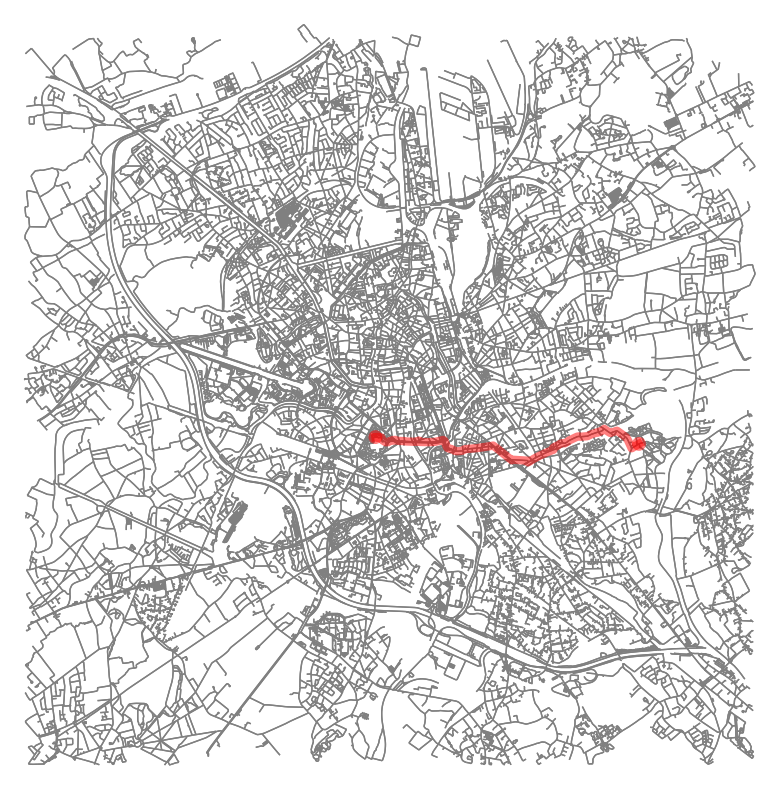

(<Figure size 1000x1000 with 1 Axes>, <Axes: >)

In [35]:
# Define a start address:
start_address = "Eugene-felixdreef 1, ghent Belgium"

start_node = translate_address(graph, geolocator, start_address, False)

# Run Dijkstra's algorithm to get the shortest paths from the start node
distances, predecessors = nx.single_source_dijkstra(graph, source=start_node, weight='length')  # 'length' is the edge attribute for distance

# Set target distance (5 km)
target_distance = 5000  # in kilometers
threshold = 50  # in kilometers (± 200 meters)

# Filter nodes that are within the threshold distance
close_nodes = {node: distance for node, distance in distances.items() if abs(distance - target_distance) <= threshold}
print("Number of possible nodes", len(close_nodes))

# Select a target node, the one that is about 5 km away (choose any from close_nodes)
target_node = list(close_nodes.keys())[0]  # Select the first node (or choose based on your preference)

# Get the specific route between start_node and target_node
route = nx.shortest_path(graph, source=start_node, target=target_node, weight='length')

# Print the nodes along the route
#print("Route from start to target (in kilometers):")
#for node in route:
#    print(node, distances[node])

# Visualize the route on the map
fig, ax = plt.subplots(figsize=(10, 10))
# Plot the full graph
ox.plot_graph(graph, ax=ax, node_size=0, edge_color='gray', bgcolor='white', show=False)
# Plot the specific route
ox.plot_graph_route(graph, route, route_linewidth=6, node_size=0, bgcolor='white', ax=ax, show=True)

# You can save the plot to a file if needed
# plt.savefig('route_map.png', dpi=300)


In [10]:
distances

{5578261551: 0,
 5578261552: 0.0033363214250905987,
 5578261556: 0.005964607034651067,
 5578261575: 0.008664898835154991,
 5578261557: 0.00889454917617172,
 5578261560: 0.011585193577807709,
 6627642399: 0.012355806156391421,
 2479402644: 0.014244919577668692,
 256261687: 0.017480618794757322,
 5578261573: 0.017640623438319,
 5578261562: 0.018093265675347865,
 2526655565: 0.020344998189206508,
 5578261570: 0.020794126825868533,
 5578261564: 0.020935030498607923,
 2479402628: 0.021383994913749725,
 5578261558: 0.02347108118986832,
 5578261566: 0.02360175763261204,
 5872457948: 0.0262968701305151,
 3387829955: 0.029130542449657452,
 1242340327: 0.03201940607378116,
 5872457943: 0.032754671184035175,
 2526655558: 0.03515072060801219,
 5578261571: 0.035212317491537,
 6627642405: 0.03564170984582298,
 5578261565: 0.035662463517995346,
 5578261567: 0.03824698724470507,
 1242340278: 0.044369416031250615,
 3387829958: 0.04678328923005409,
 6627642403: 0.048798165300611686,
 4764798714: 0.05630

In [18]:
city_edges


osmid  \
u           v           key                                                      
145679      96158030    0                                             39215287   
145715      56537191    0                                             19207591   
            205294656   0          [307416345, 1066966715, 19207590, 19207591]   
            2040932329  0                    [116181305, 233511331, 262472955]   
145763      10608884795 0    [237303363, 658608134, 242016456, 12141436, 12...   
...                                                                        ...   
12431669918 7938348732  0                                            241245428   
            12431669926 0                                           1343573787   
12431669926 12431669918 0                                           1343573787   
            1453819527  0                                           1343573788   
            12312641478 0                                           1343573788   

                                 highway lanes maxspeed  \
u           v           key                               
145679      96158030    0          trunk     1       70   
145715      56537191    0          trunk     2       90   
            205294656   0          trunk     2       90   
            2040932329  0     trunk_link     2       70   
145763      10608884795 0       tertiary     2       50   
...                                  ...   ...      ...   
12431669918 7938348732  0    residential   NaN       30   
            12431669926 0           path   NaN      NaN   
12431669926 12431669918 0           path   NaN      NaN   
            1453819527  0           path   NaN      NaN   
            12312641478 0           path   NaN      NaN   

                                                                      name  \
u           v           key                                                  
145679      96158030    0                             Buitenring Merelbeke   
145715      56537191    0                            Binnenring-Zwijnaarde   
            205294656   0    [Binnenring Merelbeke, Binnenring-Zwijnaarde]   
            2040932329  0                                              NaN   
145763      10608884795 0        [Achilles Heyndrickxlaan, Burggravenlaan]   
...                                                                    ...   
12431669918 7938348732  0                               Achtenkouterstraat   
            12431669926 0                                              NaN   
12431669926 12431669918 0                                              NaN   
            1453819527  0                                              NaN   
            12312641478 0                                              NaN   

                             oneway  ref reversed      length  \
u           v           key                                     
145679      96158030    0     False   R4     True  207.055666   
145715      56537191    0     False   R4    False  212.106300   
            205294656   0     False   R4     True  923.740001   
            2040932329  0     False  NaN    False  138.546316   
145763      10608884795 0     False  NaN     True  305.044403   
...                             ...  ...      ...         ...   
12431669918 7938348732  0     False  NaN     True   59.069287   
            12431669926 0     False  NaN     True   49.661532   
12431669926 12431669918 0     False  NaN    False   49.661532   
            1453819527  0     False  NaN    False   81.485686   
            12312641478 0     False  NaN     True   55.832475   

                                                                      geometry  \
u           v           key                                                      
145679      96158030    0    LINESTRING (3.76975 51.00373, 3.76991 51.00358...   
145715      56537191    0    LINESTRING (3.73459 51.01288, 3.73236 51.01351...   
            205294656   0    LINESTRING (3.73459 

In [19]:
start_lat, start_lon

(51.03915732495324, 3.7205452603947324)

In [20]:
close_nodes

{260446011: 4950.217425370425,
 2641473209: 4950.2613604328735,
 475907458: 4950.8330155706335,
 760325460: 4951.31508078592,
 8289500561: 4951.359401514661,
 1039525646: 4951.472842181663,
 11120879822: 4951.558463651561,
 9331597600: 4951.958452991452,
 12207839113: 4952.409617711288,
 2925705005: 4952.479617578806,
 9328141218: 4952.529956101187,
 488571061: 4952.542282785209,
 1605813563: 4952.579560004035,
 10990188420: 4952.662355760322,
 287524192: 4952.699464601255,
 2494816090: 4952.716846399875,
 6397967619: 4952.988859671178,
 12207839122: 4953.429462610332,
 367220748: 4953.5096368874165,
 11247731210: 4953.58096846568,
 2870359863: 4953.6659964115515,
 4016437092: 4953.986280634587,
 4016436896: 4954.265380047874,
 245090740: 4954.270867766518,
 11002858572: 4954.342034802983,
 11135136893: 4954.429591547039,
 9328125785: 4954.502669924313,
 367220736: 4954.518819542,
 110017580: 4954.570133079794,
 6241967874: 4955.204645492942,
 12207828195: 4955.332426217647,
 287524285

In [83]:
# Points of interest: Gravensteen: Sint-Veerleplein 11 9000 Gent, Museum of industry: Minnemeers 10, Flowrts for sint rita: Sint-Margrietstraat, Lievekaai
# Define the addresses
addresses = {
    "Gravensteen": "Sint-Veerleplein 11, 9000 Gent, Belgium",
    "Museum of Industry": "Minnemeers 10, 9000 Gent, Belgium",
    "Sint Rita": "Sint-Margrietstraat 1, 9000 Gent, Belgium", 
    "Lievekaai": "Lievekaai 1, 9000 Gent, Belgium",
    "St. Bavo's Cathedral": "Sint-Baafsplein, 9000 Gent, Belgium",
    "Ghent University Botanical Garden": "Karel Lodewijk Ledeganckstraat 35, 9000 Gent, Belgium",
    "STAM Ghent City Museum": "Godshuizenlaan 2, 9000 Gent, Belgium",
    "Design Museum Gent": "Jan Breydelstraat 5, 9000 Gent, Belgium",
    "Belfry of Ghent": "Sint-Baafsplein, 9000 Gent, Belgium",
    "Citadelpark": "Citadelpark, 9000 Gent, Belgium",
    "Patershol": "Kraanlei, 9000 Gent, Belgium",
    "Korenmarkt": "Korenmarkt, 9000 Gent, Belgium",
    "The House of Alijn": "Kraanlei 65, 9000 Gent, Belgium",
    "MIAT Museum": "Minnemeers 10, 9000 Gent, Belgium",
    "SMAK Museum of Contemporary Art": "Jan Hoetplein 1, 9000 Gent, Belgium"
}

predefined_coords = {
    "Gravensteen": (51.056279, 3.720084),
    "Museum of Industry": (51.063314, 3.728368),
    "Sint Rita": (51.047553, 3.717246),
    "Lievekaai": (51.056810, 3.721897),
    "St. Bavo's Cathedral": (51.053541, 3.725765),
    "Ghent University Botanical Garden": (51.030263, 3.710734),
    "STAM Ghent City Museum": (51.046202, 3.721773),
    "Design Museum Gent": (51.054369, 3.718559),
    "Belfry of Ghent": (51.053468, 3.724911),
    "Citadelpark": (51.036299, 3.718643),
    "Patershol": (51.056057, 3.720400),
    "Korenmarkt": (51.053949, 3.720967),
    "The House of Alijn": (51.056587, 3.721885),
    "MIAT Museum": (51.063109, 3.728113),
    "SMAK Museum of Contemporary Art": (51.037662, 3.710559)
}


## Genetic Algorithm Implementation

In [70]:
# Fitness Function
# The fitness function evaluates how close the total length of a path is to the target distance
def fitness(graph, path, target_distance):
    path_length = sum(
        nx.shortest_path_length(graph, path[i], path[i + 1], weight='length')
        for i in range(len(path) - 1)
    )
    # Penalize paths that exceed the target distance
    return -abs(target_distance - path_length) - (0.1 * max(0, path_length - target_distance))


In [69]:
# Crossover
# Combine two parent paths to create an offspring path
def crossover(parent1, parent2):
    split_idx = random.randint(1, len(parent1) - 2)
    child = parent1[:split_idx] + [node for node in parent2 if node not in parent1[:split_idx]]
    return child

In [68]:
# Mutation
# Introduce small changes to paths
def mutate(path):
    idx1, idx2 = random.sample(range(1, len(path) - 1), 2)  # Avoid start node
    path[idx1], path[idx2] = path[idx2], path[idx1]
    return path

In [67]:
# Initialize Population
# Generate random paths:
def initialize_population(nodes, population_size):
    population = []
    for _ in range(population_size):
        path = nodes[1:]  # Exclude the start node
        random.shuffle(path)
        path = [nodes[0]] + path  # Add start node back
        population.append(path)
    return population

In [97]:
def genetic_algorithm_with_history(graph, nodes, start_node, target_distance, population_size=100, generations=200, mutation_rate=0.1):
    nodes = [start_node] + list(nodes.values())  # Include start node
    population = initialize_population(nodes, population_size)
    history = []  # To store the best path of each generation
    best_path = None
    best_length = float('inf')
    
    for generation in range(generations):
        # Evaluate fitness
        population_fitness = [(path, fitness(graph, path, target_distance)) for path in population]
        population_fitness.sort(key=lambda x: x[1], reverse=True)  # Sort by fitness descending

        # Save the best path of this generation
        current_best_path, _ = population_fitness[0]
        history.append(current_best_path)

        # Update the best path and length if current path is better
        current_length = sum(
            nx.shortest_path_length(graph, current_best_path[i], current_best_path[i + 1], weight='length')
            for i in range(len(current_best_path) - 1)
        )
        if abs(target_distance - current_length) < abs(target_distance - best_length):
            best_path = current_best_path
            best_length = current_length
        
        print(f"Generation: [{generation+1}/{generations}] --- Best path: {population_fitness[0][0]} with length: {best_length}")

        # Select parents
        parents = [path for path, _ in population_fitness[:population_size // 2]]

        # Generate next generation
        next_generation = parents[:]
        while len(next_generation) < population_size:
            parent1, parent2 = random.sample(parents, 2)
            child = crossover(parent1, parent2)
            if random.random() < mutation_rate:  # Mutation probability
                child = mutate(child)
            next_generation.append(child)

        population = next_generation
    
    return best_path, best_length, history


In [ ]:
nodes_to_visit = dict()

for monument in addresses.keys():
    current = addresses[monument]
    nodes_to_visit[monument] = translate_address(graph, geolocator, current, False)

print("Nodes dict:", nodes_to_visit)

In [84]:
nodes_to_visit = {name: ox.distance.nearest_nodes(graph, coord[1], coord[0]) for name, coord in predefined_coords.items()}

In [98]:
# Define the graph and nodes
start_address = "Eugene-felixdreef 1, ghent Belgium"
start_node = translate_address(graph, geolocator, start_address, False)

# Run GA
target_distance = 10000  # Target distance in meters
best_path, best_length, history = genetic_algorithm_with_history(graph, nodes_to_visit, start_node, target_distance, generations = 20, mutation_rate=0.5)
print("Best Path:", best_path)
print("Path Length:", best_length)

Generation number: [1/20] --- Best fitness: [5578261551, 4408537033, 4408537042, 247108130, 249190808, 440871168, 440871168, 2593733503, 82775037, 245419784, 2887222629, 1212148854, 1212150357, 7962515361, 53331070, 3387829926], Best length: 15848.134543555247
Generation number: [2/20] --- Best fitness: [5578261551, 82775037, 4408537042, 2593733503, 4408537033, 7962515361, 1212148854, 245419784, 2887222629, 53331070, 3387829926, 249190808, 440871168, 440871168, 247108130, 1212150357], Best length: 15753.310431424152
Generation number: [3/20] --- Best fitness: [5578261551, 4408537033, 4408537042, 247108130, 249190808, 440871168, 440871168, 2593733503, 82775037, 1212148854, 7962515361, 1212150357, 245419784, 2887222629, 3387829926, 53331070], Best length: 11393.738252425452
Generation number: [4/20] --- Best fitness: [5578261551, 4408537033, 4408537042, 247108130, 249190808, 440871168, 440871168, 2593733503, 82775037, 1212148854, 7962515361, 1212150357, 245419784, 2887222629, 3387829926,

In [106]:
def plot_path(graph, path, ax=None):
    if ax is None:
        fig, ax = plt.subplots(figsize=(10, 10))
    
    # Plot the base graph
    ox.plot_graph(graph, ax=ax, show=False, close=False, bgcolor='white', edge_color='black', node_color='black', node_size=1, edge_linewidth=0.5)

    # Gather all edges for the path
    edges = []
    for i in range(len(path) - 1):
        route = nx.shortest_path(graph, path[i], path[i + 1], weight='length')
        edges += list(zip(route[:-1], route[1:]))
    
    # Get node coordinates for plotting
    node_positions = {node: (graph.nodes[node]['x'], graph.nodes[node]['y']) for node in graph.nodes}
    edge_positions = [(node_positions[edge[0]], node_positions[edge[1]]) for edge in edges]

    # Plot the path edges
    for start, end in edge_positions:
        ax.plot([start[0], end[0]], [start[1], end[1]], color='red', linewidth=2, zorder=3)

    # Highlight the nodes in the path
    path_coords = [node_positions[node] for node in path]
    path_x, path_y = zip(*path_coords)
    ax.scatter(path_x, path_y, color='blue', s=50, zorder=4)

    # Annotate nodes
    for idx, (x, y) in enumerate(path_coords):
        ax.text(x, y, str(idx), fontsize=10, ha='center', va='center', color='black', zorder=5)

    plt.title("Path Visualization on Map")
    plt.xlabel("Longitude")
    plt.ylabel("Latitude")
    plt.show()


In [107]:
def visualize_history(graph, history):
    @interact(generation=IntSlider(min=0, max=len(history)-1, step=1, value=0))
    def show_generation(generation):
        fig, ax = plt.subplots(figsize=(12, 12))
        plot_path(graph, history[generation], ax=ax)
        ax.set_title(f"Generation: {generation+1}")


In [108]:
visualize_history(graph, history)

interactive(children=(IntSlider(value=0, description='generation', max=19), Output()), _dom_classes=('widget-i…